# Tau PT Regression + JetID Classification Merge

In this notebook we will implement a NN that merges the regression and classification NN that we developed for pT regression and jetID, respectively.

In [3]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/merged_pt_regress_jet_ID.h5'

2023-06-22 14:47:49.924388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 14:47:50.119519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-22 14:47:50.119545: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-22 14:47:58.287877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [2]:
#You only need to run this once
def create_training_data_pT_regression(dir_path, test_index=400000):
    '''
    test_index: 400000 
    All the data before test_index are used for training. And all the data after it is used for testing.
    '''
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
    print(inputs)
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[:test_index]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_train = np.nan_to_num(np.asarray(inputs[selection]))
    y_train = np.asarray(truth_pt[selection]/reco_pt[selection])
    
    X_train[abs(X_train) > 1e+9] = 0.

    np.save(dir_path+"/X_train.npy", X_train)
    np.save(dir_path+"/y_train.npy", y_train)
print(create_training_data_pT_regression("../../ntuples/Jan_25_2023"))
X_train_pT_regress = np.load("../../ntuples/Jan_25_2023/X_train.npy")
y_train_pT_regress = np.load("../../ntuples/Jan_25_2023/y_train.npy")
print(X_train_pT_regress)
print(y_train_pT_regress)

[[89.5, 0, 0, 0, 0, 0, 0, 1, 8.25, -0.0938, -0.25, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
None
[[89.5   0.    0.   ...  0.    0.    0.  ]
 [28.75  0.    0.   ...  0.    0.    0.  ]
 [51.    0.    0.   ...  0.    0.    0.  ]
 ...
 [29.75  0.    0.   ...  0.    0.    0.  ]
 [20.25  0.    0.   ...  0.    0.    0.  ]
 [21.5   0.    0.   ...  0.    0.    0.  ]]
[0.9832559  1.8645984  0.84331274 ... 0.8675887  0.9550117  1.1139913 ]


[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


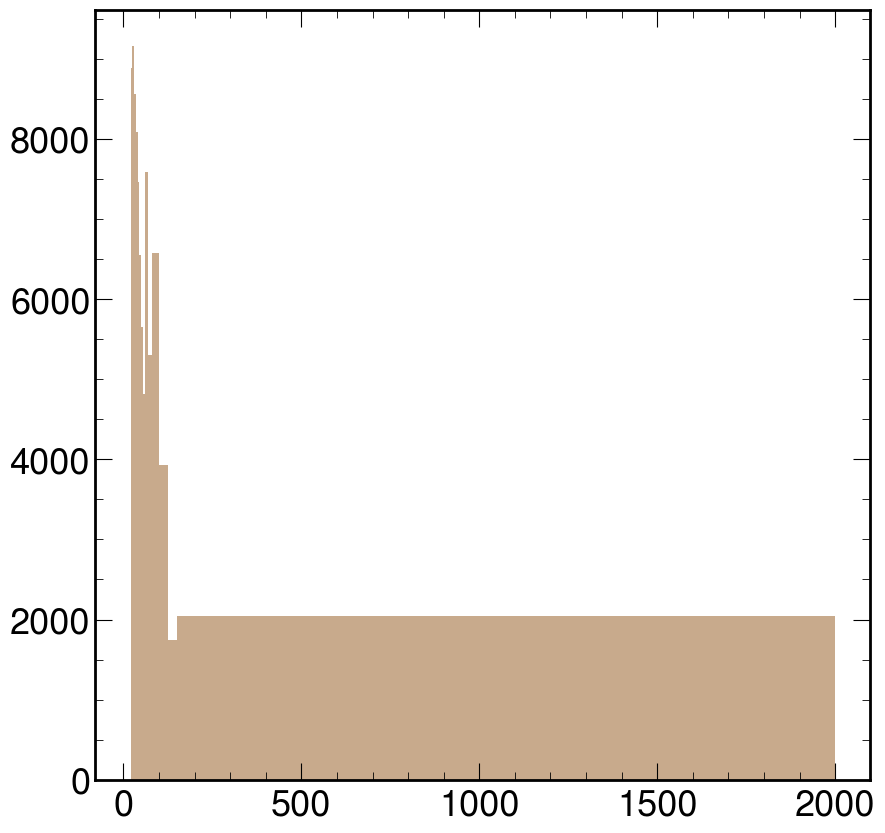

[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 3.7000e+01  0.0000e+00  3.1250e-02 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 9.8000e+01 -1.5625e-02  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.2500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
[1. 1. 1. ... 0. 0. 0.]
[1.         1.         1.         ... 0.58678202 0.94007676 0.31060527]


In [4]:
def make_weights(sig_pt, reco_bkg_pt, pt_edges = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,2000]):
    
    weight_pt_bkg = np.zeros(reco_bkg_pt.shape)
    
    sig_hist, sig_bin_edges = np.histogram(sig_pt, bins = pt_edges)
    bkg_hist, bkg_bin_edges = np.histogram(reco_bkg_pt, bins = pt_edges)
    
    scale_factor = [sig_hist[i]/bkg_hist[i] for i in range(len(sig_bin_edges)-1)]
    
    #Assign the weights to qcd jets
    for i in range(len(sig_bin_edges)-1):
        weight_pt_bkg[(reco_bkg_pt >= sig_bin_edges[i]) & (reco_bkg_pt < sig_bin_edges[i+1])] = scale_factor[i]
    
    #weight_pt_bkg[reco_bkg_pt > 100] = weight_pt_bkg[reco_bkg_pt > 100]/2. #Give less weights for high pT background (v4)
    
    weight_pt_sig = np.ones(sig_pt.shape)
    weight_pt_sig[sig_pt > 100.] = 2 #Give more importance to high pT signal (v2 + v3)
#     weight_pt_sig[sig_pt > 120.] = 5. #Give more importance to high pT signal (v3)
    all_weight = np.concatenate([weight_pt_sig, weight_pt_bkg])
    
    return all_weight

def create_training_data_jetID(dir_path):
    
    pt_edges = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,2000]
    
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
    qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()
    
    truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000])
    truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:400000])
    truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
    
    reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:400000]
    deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
    eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]
    #selection_sig = (truth_pt_sig > 20.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
    selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
    y_sig_pT = truth_pt_sig[selection_sig]
    
    reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:400000]
    selection_bkg = reco_pt_bkg > 20.
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 20.
    y_qcd_pT = truth_pt_qcd[selection_qcd]
    
    #Maybe better to use 2.4 for eta
    
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    print(y_sig, y_bkg, y_qcd)
    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pt, y_qcd_pT / qcd_pt])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    sample_weight = make_weights(sig_pt, background_pt, pt_edges)
    
    X_train[abs(X_train) > 1e+4] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    plt.hist(sig_pt, bins = pt_edges, alpha=0.4)
    plt.hist(background_pt, bins = pt_edges, alpha=0.4, weights=sample_weight[-len(background_pt):])
    plt.show()
    
    return X_train, y_train_jetID, sample_weight, y_train_pT
X_train_jetID, y_train_jetID, sample_weight_jetID, y_train_pT_regress = create_training_data_jetID("../../ntuples/Jan_25_2023")
print(X_train_jetID)
print(y_train_jetID)
print(sample_weight_jetID)


In [5]:
print(len(X_train_jetID))
print(len(y_train_jetID))
print(len(y_train_pT_regress))
print(X_train_jetID)
print(y_train_pT_regress)

282390
282390
282390
[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 3.7000e+01  0.0000e+00  3.1250e-02 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 9.8000e+01 -1.5625e-02  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.2500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
[0.9832559  1.8645984  0.84331274 ... 0.         0.         0.        ]


## Model

In [5]:
# Merged Model Architecture

def merged_model(gamma):

    inputs = tf.keras.layers.Input(shape=(80,), name='input')

    main_branch = tf.keras.layers.Dense(25, activation = "LeakyReLU")(inputs)
    main_branch = tf.keras.layers.Dense(25, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(10, activation = "LeakyReLU")(main_branch)

    jetID_branch = tf.keras.layers.Dense(1, activation='sigmoid', name='jetID_output')(main_branch)

    pT_branch = tf.keras.layers.Dense(1, name='pT_output')(main_branch)

    model = tf.keras.Model(inputs = inputs, outputs = [jetID_branch, pT_branch])
    
    return model

In [6]:
# Coupling Loss Functions

def compile_model(model, gamma):
    opt = optimizers.Adam(learning_rate = 0.005)
    model.compile(optimizer=opt,
                  loss={'jetID_output': 'binary_crossentropy', 
                        'pT_output': 'mean_squared_error'},
                  loss_weights={'jetID_output': gamma, 
                                'pT_output': 1 - gamma}, 
                  metrics=['accuracy'])
        
    return model

In [7]:
# Joint Loss function is defined as Loss = gamma * Loss_task1 + (1-gamma) * Loss_task2
gamma = 0
model = merged_model(gamma)
model = compile_model(model, gamma)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 25)           2025        ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 25)           650         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 15)           390         ['dense_1[0][0]']                
                                                                                              

2023-06-22 11:58:20.256943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import time
X_train = X_train_jetID

# FIT BATCH OF MODELS

def fit_batch(gamma_values):
    
    history = list()
    trained_models = list()
    
    print('Starting training on batch of models for gamma values ', gamma_values, '\n\n')
    
    for gamma in gamma_values:
        #callback = tf.keras.callbacks.EarlyStopping(verbose = 1, patience=5)
        print('Training model for gamma equal to ', gamma)
        model = merged_model(gamma)
        model = compile_model(model, gamma)
        model.summary()
        start = time.time()
        model_history = model.fit({'input': X_train},
                            {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
                            epochs=30, batch_size=128, verbose=2)
        print(f'Training time: {time.time() - start}\n')
        history.append(model_history)
        trained_models.append(model)
        
    return history, trained_models

In [9]:
gammas = np.linspace(0, 1, 10)
training_history, trained_models = fit_batch(gammas)

Starting training on batch of models for gamma values  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ] 


Training model for gamma equal to  0.0
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 25)           2025        ['input[0][0]']                  
                                                                                                  
 dense_6 (Dense)                (None, 25)           650         ['dense_5[0][0]']                
                                                                                

                                                                                                  
 dense_10 (Dense)               (None, 25)           2025        ['input[0][0]']                  
                                                                                                  
 dense_11 (Dense)               (None, 25)           650         ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 15)           390         ['dense_11[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 15)           240         ['dense_12[0][0]']               
                                                                                                  
 dense_14 (Dense)               (None, 10)           160         ['dense_13[0][0]']               
          

 dense_18 (Dense)               (None, 15)           240         ['dense_17[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 10)           160         ['dense_18[0][0]']               
                                                                                                  
 jetID_output (Dense)           (None, 1)            11          ['dense_19[0][0]']               
                                                                                                  
 pT_output (Dense)              (None, 1)            11          ['dense_19[0][0]']               
                                                                                                  
Total params: 3,487
Trainable params: 3,487
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
2207/2207 - 4s - loss: 0.2882 

                                                                                                  
Total params: 3,487
Trainable params: 3,487
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
2207/2207 - 4s - loss: 0.2844 - jetID_output_loss: 0.3233 - pT_output_loss: 0.2650 - jetID_output_accuracy: 0.8514 - pT_output_accuracy: 0.5233 - 4s/epoch - 2ms/step
Epoch 2/30
2207/2207 - 4s - loss: 0.2516 - jetID_output_loss: 0.2948 - pT_output_loss: 0.2301 - jetID_output_accuracy: 0.8687 - pT_output_accuracy: 0.5437 - 4s/epoch - 2ms/step
Epoch 3/30
2207/2207 - 4s - loss: 0.2475 - jetID_output_loss: 0.2916 - pT_output_loss: 0.2254 - jetID_output_accuracy: 0.8700 - pT_output_accuracy: 0.5449 - 4s/epoch - 2ms/step
Epoch 4/30
2207/2207 - 4s - loss: 0.2452 - jetID_output_loss: 0.2888 - pT_output_loss: 0.2234 - jetID_output_accuracy: 0.8711 - pT_output_accuracy: 0.5462 - 4s/epoch - 2ms/step
Epoch 5/30
2207/2207 - 4s 

Epoch 3/30
2207/2207 - 4s - loss: 0.2540 - jetID_output_loss: 0.2895 - pT_output_loss: 0.2256 - jetID_output_accuracy: 0.8709 - pT_output_accuracy: 0.5440 - 4s/epoch - 2ms/step
Epoch 4/30
2207/2207 - 3s - loss: 0.2510 - jetID_output_loss: 0.2863 - pT_output_loss: 0.2227 - jetID_output_accuracy: 0.8722 - pT_output_accuracy: 0.5446 - 3s/epoch - 2ms/step
Epoch 5/30
2207/2207 - 3s - loss: 0.2484 - jetID_output_loss: 0.2846 - pT_output_loss: 0.2194 - jetID_output_accuracy: 0.8732 - pT_output_accuracy: 0.5452 - 3s/epoch - 2ms/step
Epoch 6/30
2207/2207 - 3s - loss: 0.2479 - jetID_output_loss: 0.2838 - pT_output_loss: 0.2192 - jetID_output_accuracy: 0.8735 - pT_output_accuracy: 0.5462 - 3s/epoch - 2ms/step
Epoch 7/30
2207/2207 - 4s - loss: 0.2463 - jetID_output_loss: 0.2821 - pT_output_loss: 0.2177 - jetID_output_accuracy: 0.8745 - pT_output_accuracy: 0.5480 - 4s/epoch - 2ms/step
Epoch 8/30
2207/2207 - 4s - loss: 0.2445 - jetID_output_loss: 0.2806 - pT_output_loss: 0.2156 - jetID_output_accura

Epoch 7/30
2207/2207 - 4s - loss: 0.2526 - jetID_output_loss: 0.2809 - pT_output_loss: 0.2171 - jetID_output_accuracy: 0.8750 - pT_output_accuracy: 0.5468 - 4s/epoch - 2ms/step
Epoch 8/30
2207/2207 - 4s - loss: 0.2518 - jetID_output_loss: 0.2798 - pT_output_loss: 0.2169 - jetID_output_accuracy: 0.8748 - pT_output_accuracy: 0.5497 - 4s/epoch - 2ms/step
Epoch 9/30
2207/2207 - 4s - loss: 0.2503 - jetID_output_loss: 0.2786 - pT_output_loss: 0.2150 - jetID_output_accuracy: 0.8761 - pT_output_accuracy: 0.5504 - 4s/epoch - 2ms/step
Epoch 10/30
2207/2207 - 3s - loss: 0.2503 - jetID_output_loss: 0.2784 - pT_output_loss: 0.2152 - jetID_output_accuracy: 0.8760 - pT_output_accuracy: 0.5495 - 3s/epoch - 2ms/step
Epoch 11/30
2207/2207 - 3s - loss: 0.2497 - jetID_output_loss: 0.2777 - pT_output_loss: 0.2147 - jetID_output_accuracy: 0.8761 - pT_output_accuracy: 0.5493 - 3s/epoch - 2ms/step
Epoch 12/30
2207/2207 - 4s - loss: 0.2489 - jetID_output_loss: 0.2771 - pT_output_loss: 0.2136 - jetID_output_acc

Epoch 11/30
2207/2207 - 3s - loss: 0.2562 - jetID_output_loss: 0.2769 - pT_output_loss: 0.2150 - jetID_output_accuracy: 0.8762 - pT_output_accuracy: 0.5505 - 3s/epoch - 2ms/step
Epoch 12/30
2207/2207 - 3s - loss: 0.2563 - jetID_output_loss: 0.2767 - pT_output_loss: 0.2156 - jetID_output_accuracy: 0.8762 - pT_output_accuracy: 0.5502 - 3s/epoch - 2ms/step
Epoch 13/30
2207/2207 - 3s - loss: 0.2560 - jetID_output_loss: 0.2764 - pT_output_loss: 0.2150 - jetID_output_accuracy: 0.8764 - pT_output_accuracy: 0.5502 - 3s/epoch - 2ms/step
Epoch 14/30
2207/2207 - 3s - loss: 0.2555 - jetID_output_loss: 0.2758 - pT_output_loss: 0.2150 - jetID_output_accuracy: 0.8766 - pT_output_accuracy: 0.5511 - 3s/epoch - 2ms/step
Epoch 15/30
2207/2207 - 4s - loss: 0.2547 - jetID_output_loss: 0.2751 - pT_output_loss: 0.2137 - jetID_output_accuracy: 0.8771 - pT_output_accuracy: 0.5512 - 4s/epoch - 2ms/step
Epoch 16/30
2207/2207 - 4s - loss: 0.2548 - jetID_output_loss: 0.2751 - pT_output_loss: 0.2142 - jetID_output_

Epoch 15/30
2207/2207 - 4s - loss: 0.2619 - jetID_output_loss: 0.2752 - pT_output_loss: 0.2154 - jetID_output_accuracy: 0.8771 - pT_output_accuracy: 0.5505 - 4s/epoch - 2ms/step
Epoch 16/30
2207/2207 - 4s - loss: 0.2614 - jetID_output_loss: 0.2748 - pT_output_loss: 0.2145 - jetID_output_accuracy: 0.8773 - pT_output_accuracy: 0.5500 - 4s/epoch - 2ms/step
Epoch 17/30
2207/2207 - 4s - loss: 0.2612 - jetID_output_loss: 0.2744 - pT_output_loss: 0.2149 - jetID_output_accuracy: 0.8774 - pT_output_accuracy: 0.5508 - 4s/epoch - 2ms/step
Epoch 18/30
2207/2207 - 4s - loss: 0.2607 - jetID_output_loss: 0.2742 - pT_output_loss: 0.2135 - jetID_output_accuracy: 0.8773 - pT_output_accuracy: 0.5502 - 4s/epoch - 2ms/step
Epoch 19/30
2207/2207 - 4s - loss: 0.2602 - jetID_output_loss: 0.2736 - pT_output_loss: 0.2133 - jetID_output_accuracy: 0.8778 - pT_output_accuracy: 0.5500 - 4s/epoch - 2ms/step
Epoch 20/30
2207/2207 - 4s - loss: 0.2606 - jetID_output_loss: 0.2736 - pT_output_loss: 0.2153 - jetID_output_

Epoch 19/30
2207/2207 - 4s - loss: 0.2667 - jetID_output_loss: 0.2728 - pT_output_loss: 0.2176 - jetID_output_accuracy: 0.8778 - pT_output_accuracy: 0.5529 - 4s/epoch - 2ms/step
Epoch 20/30
2207/2207 - 4s - loss: 0.2660 - jetID_output_loss: 0.2721 - pT_output_loss: 0.2171 - jetID_output_accuracy: 0.8784 - pT_output_accuracy: 0.5547 - 4s/epoch - 2ms/step
Epoch 21/30
2207/2207 - 4s - loss: 0.2660 - jetID_output_loss: 0.2722 - pT_output_loss: 0.2168 - jetID_output_accuracy: 0.8784 - pT_output_accuracy: 0.5533 - 4s/epoch - 2ms/step
Epoch 22/30
2207/2207 - 4s - loss: 0.2658 - jetID_output_loss: 0.2719 - pT_output_loss: 0.2171 - jetID_output_accuracy: 0.8786 - pT_output_accuracy: 0.5537 - 4s/epoch - 2ms/step
Epoch 23/30
2207/2207 - 4s - loss: 0.2661 - jetID_output_loss: 0.2721 - pT_output_loss: 0.2175 - jetID_output_accuracy: 0.8788 - pT_output_accuracy: 0.5542 - 4s/epoch - 2ms/step
Epoch 24/30
2207/2207 - 4s - loss: 0.2651 - jetID_output_loss: 0.2712 - pT_output_loss: 0.2165 - jetID_output_

Epoch 23/30
2207/2207 - 3s - loss: 0.2719 - jetID_output_loss: 0.2719 - pT_output_loss: 421.3012 - jetID_output_accuracy: 0.8787 - pT_output_accuracy: 0.1528 - 3s/epoch - 2ms/step
Epoch 24/30
2207/2207 - 3s - loss: 0.2720 - jetID_output_loss: 0.2720 - pT_output_loss: 446.3968 - jetID_output_accuracy: 0.8789 - pT_output_accuracy: 0.1473 - 3s/epoch - 2ms/step
Epoch 25/30
2207/2207 - 4s - loss: 0.2714 - jetID_output_loss: 0.2714 - pT_output_loss: 496.6401 - jetID_output_accuracy: 0.8787 - pT_output_accuracy: 0.1418 - 4s/epoch - 2ms/step
Epoch 26/30
2207/2207 - 3s - loss: 0.2713 - jetID_output_loss: 0.2713 - pT_output_loss: 438.3157 - jetID_output_accuracy: 0.8786 - pT_output_accuracy: 0.1414 - 3s/epoch - 2ms/step
Epoch 27/30
2207/2207 - 3s - loss: 0.2704 - jetID_output_loss: 0.2704 - pT_output_loss: 423.0386 - jetID_output_accuracy: 0.8792 - pT_output_accuracy: 0.1436 - 3s/epoch - 2ms/step
Epoch 28/30
2207/2207 - 3s - loss: 0.2708 - jetID_output_loss: 0.2708 - pT_output_loss: 497.2994 - j

In [10]:
# #Train the network
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

# history = model.fit({'input': X_train},
#                             {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
#                     epochs=20,
#                     batch_size=128,
#                     verbose=2,
#                     validation_split=0.20,
#                     callbacks = [callback])

In [11]:
# #Save the model
# model.save(model_name)

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

In [12]:
# # Get prediction for both tasks
# # (predictions will be done on the model trained with gamma=0.5)
# data = 
# for pred in trained_model.predict(data):
#     print('Task prediction: ', np.argmax(pred))


# make ROC curve for jetID
# pT distribution already have
# run for more gamma optimize (probably weight more on jetID?)
# all of the pT plots that we already did: eff, 95%, both rates
# 

In [13]:
import matplotlib.pyplot as plt


def plot_multitask_accuracies(gammas, training_history):
    
    counter = 0

    for history in training_history:

        print(f'\nPlotting Accuracy vs Epochs for value of gamma number {gammas[counter]}\n')
        plt.plot(range(len(history.history['jetID_output_accuracy'])), history.history['jetID_output_accuracy'], c='r', label='Task 1')
        plt.plot(range(len(history.history['pT_output_accuracy'])), history.history['pT_output_accuracy'], c='b', label='Task 2')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        counter += 1
    


Plotting Accuracy vs Epochs for value of gamma number 0.0



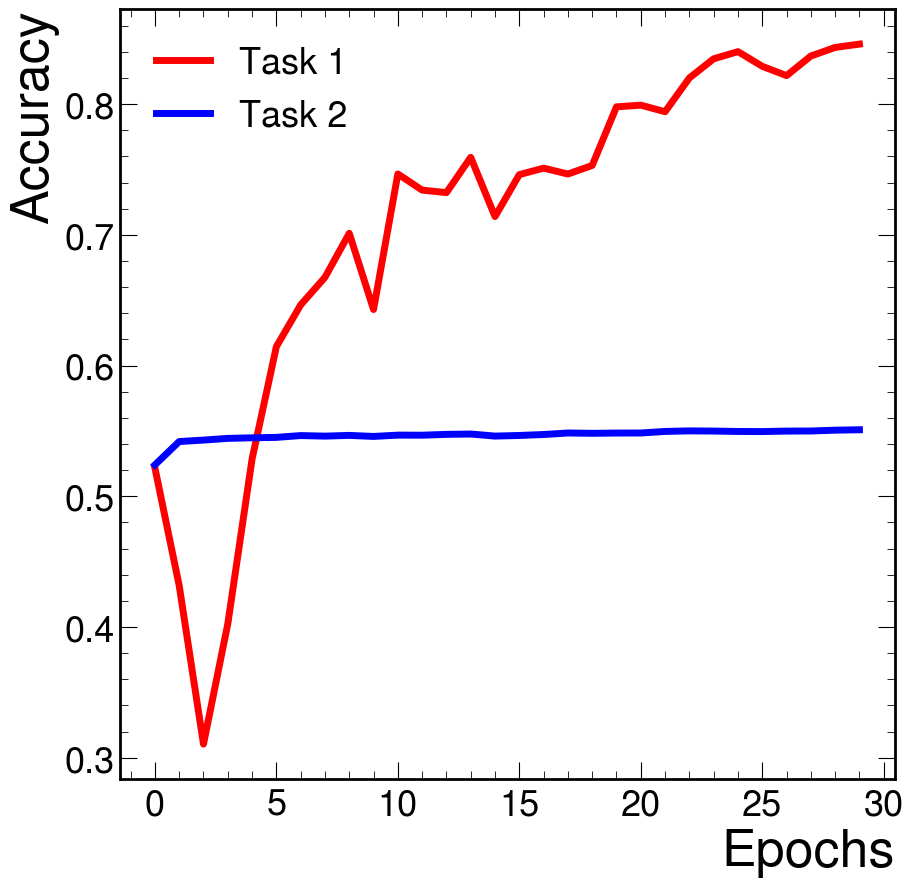


Plotting Accuracy vs Epochs for value of gamma number 0.1111111111111111



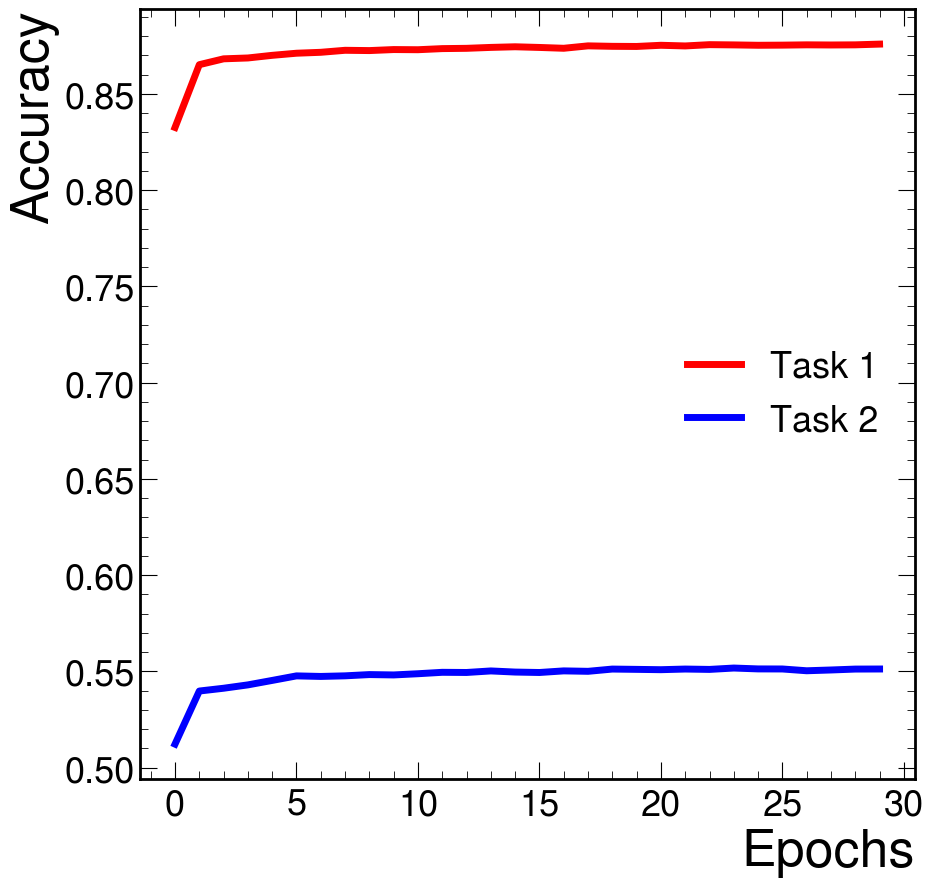


Plotting Accuracy vs Epochs for value of gamma number 0.2222222222222222



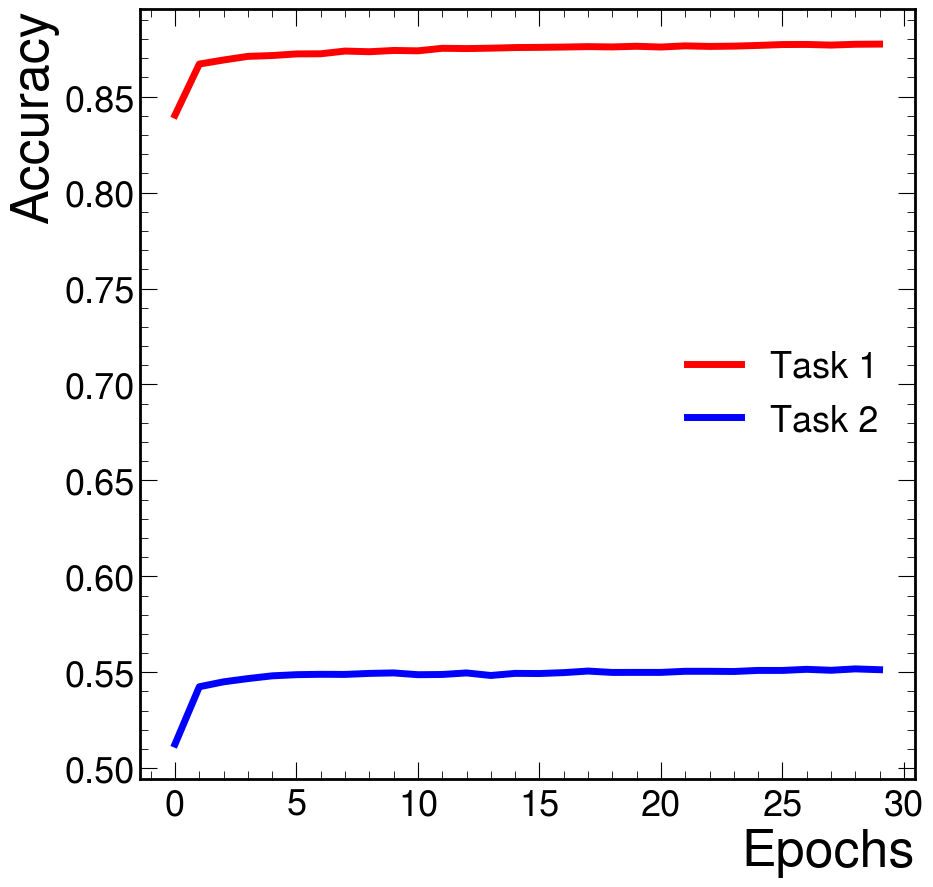


Plotting Accuracy vs Epochs for value of gamma number 0.3333333333333333



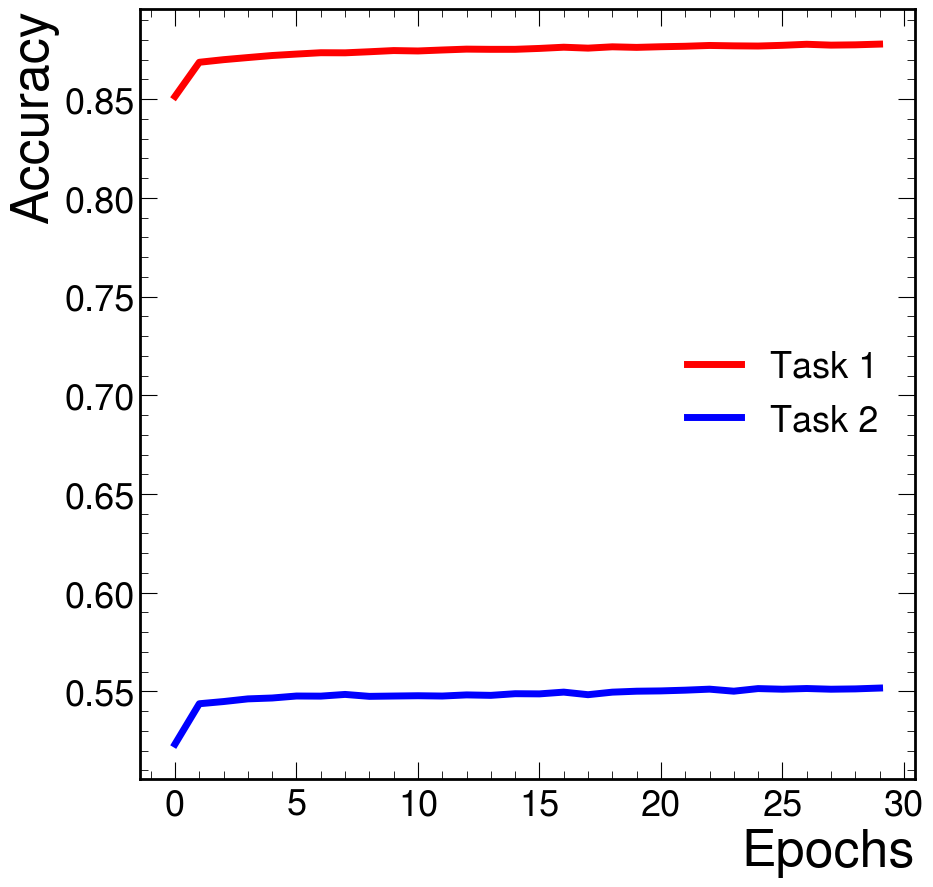


Plotting Accuracy vs Epochs for value of gamma number 0.4444444444444444



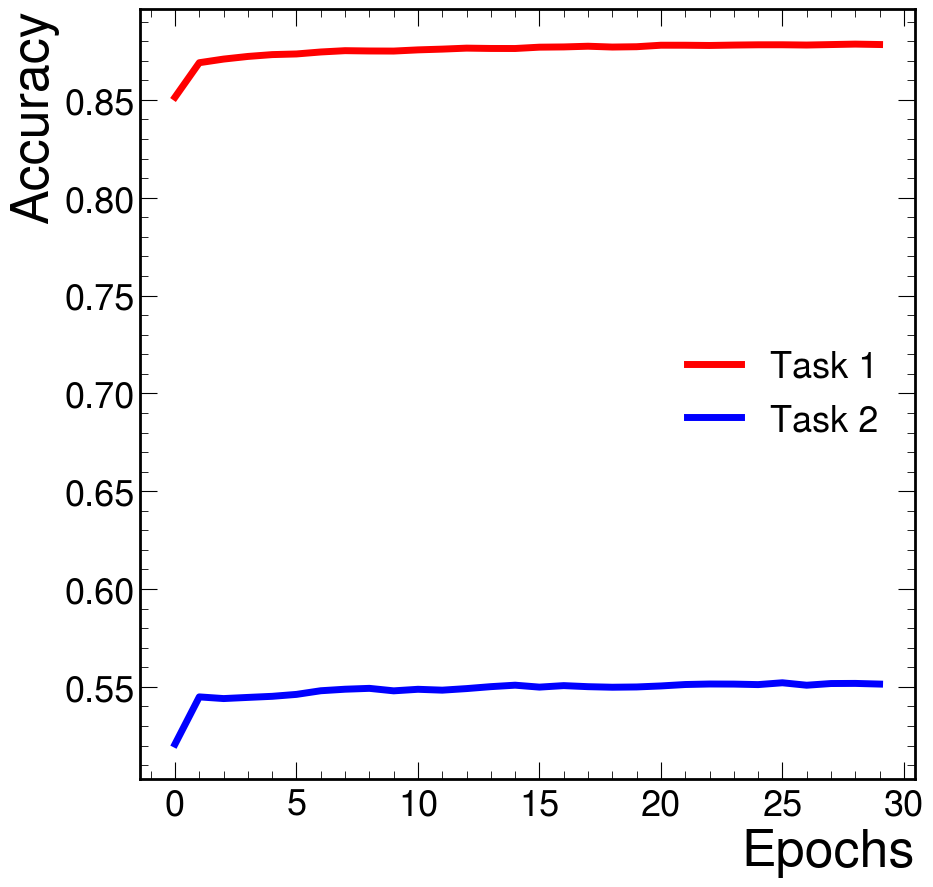


Plotting Accuracy vs Epochs for value of gamma number 0.5555555555555556



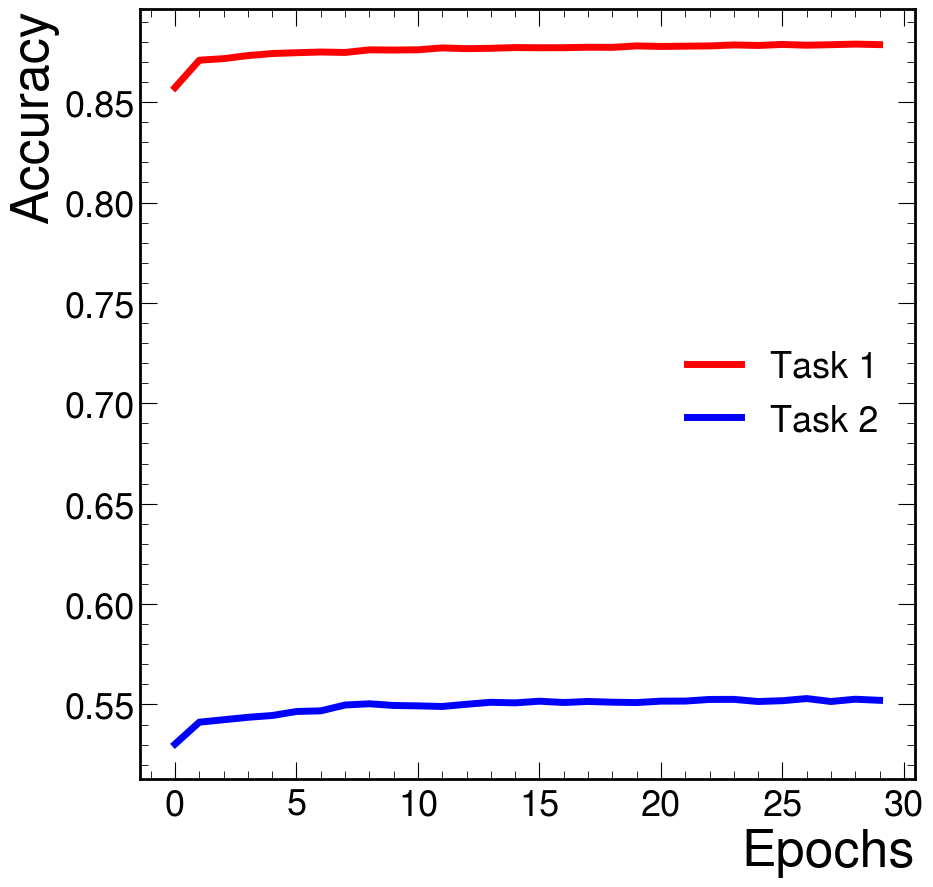


Plotting Accuracy vs Epochs for value of gamma number 0.6666666666666666



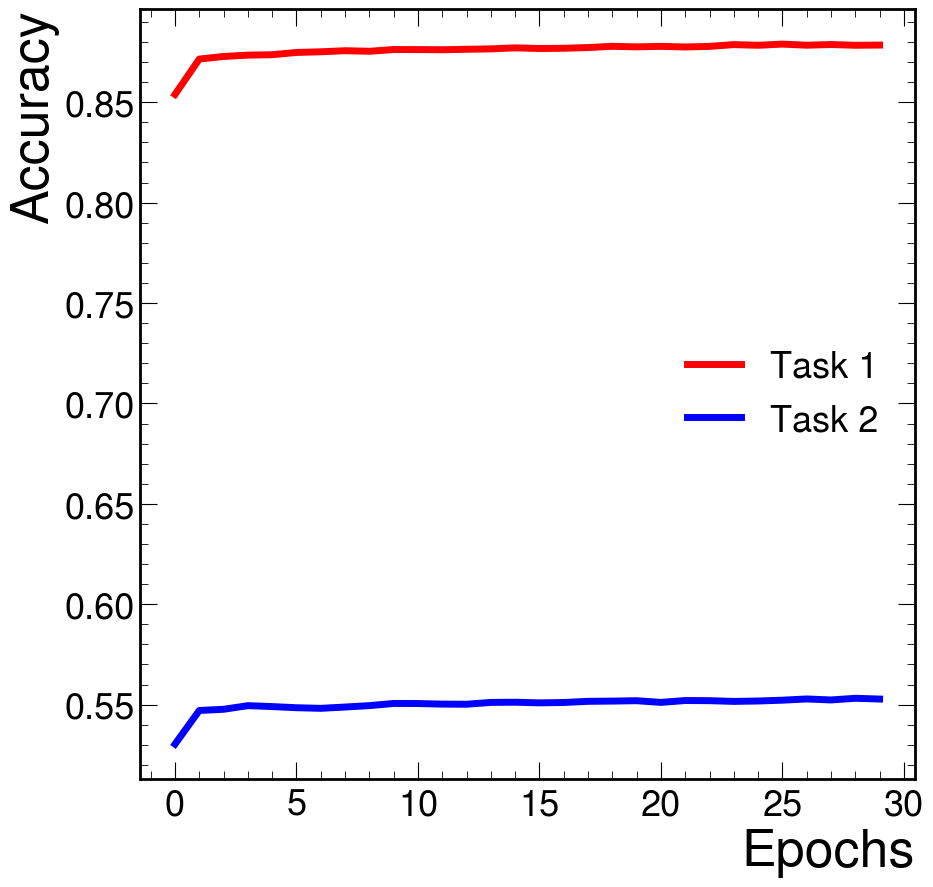


Plotting Accuracy vs Epochs for value of gamma number 0.7777777777777777



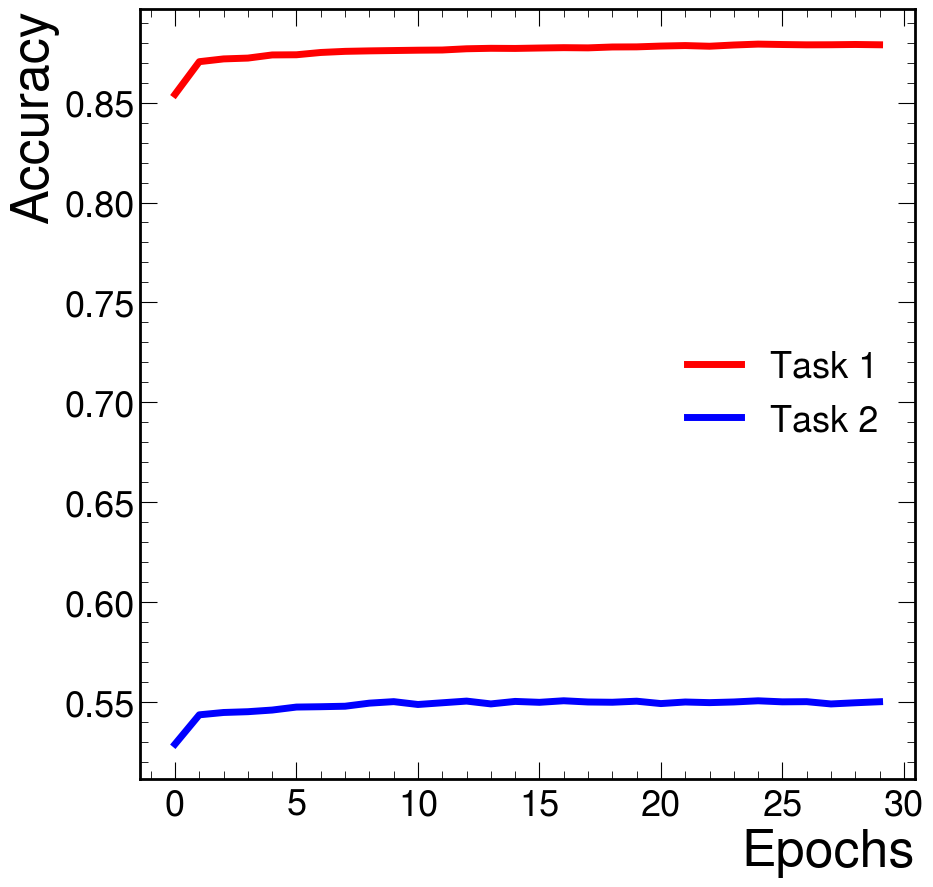


Plotting Accuracy vs Epochs for value of gamma number 0.8888888888888888



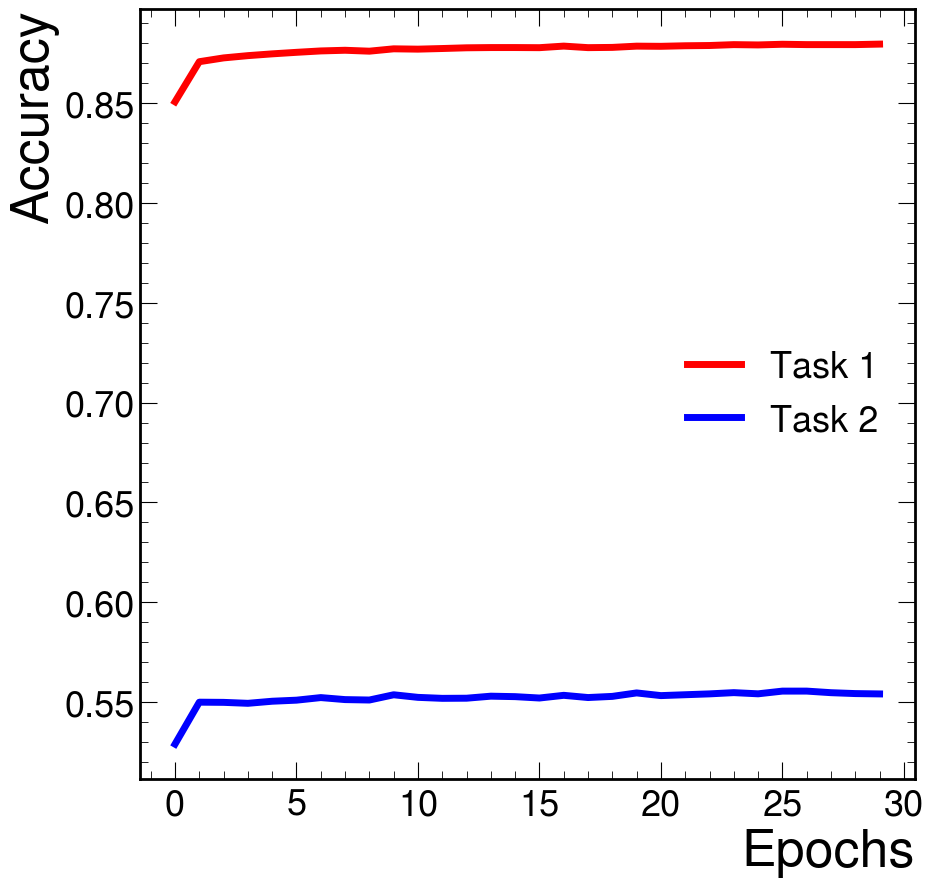


Plotting Accuracy vs Epochs for value of gamma number 1.0



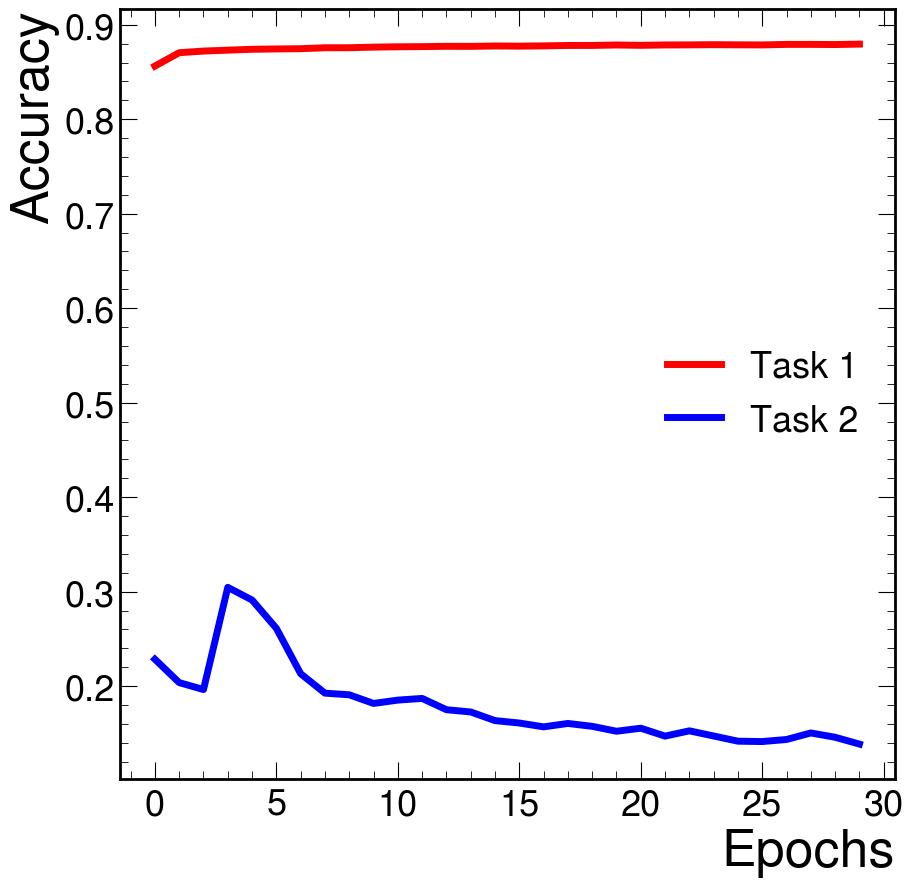

In [14]:
plot_multitask_accuracies(gammas, training_history)


In [15]:
#Load the pts and then plot the actual distributions

In [16]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten() # take the regression output
    print(y_pred)
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    print(pred_pt)
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 3s 2ms/step
[ 0.03357267 -0.29703104  7.6279793  ... -0.18235779  3.599749
 -0.15471661]
[   2.0227537  -11.509953  1407.3622    ...   -8.160511   261.88174
   -2.6301823]


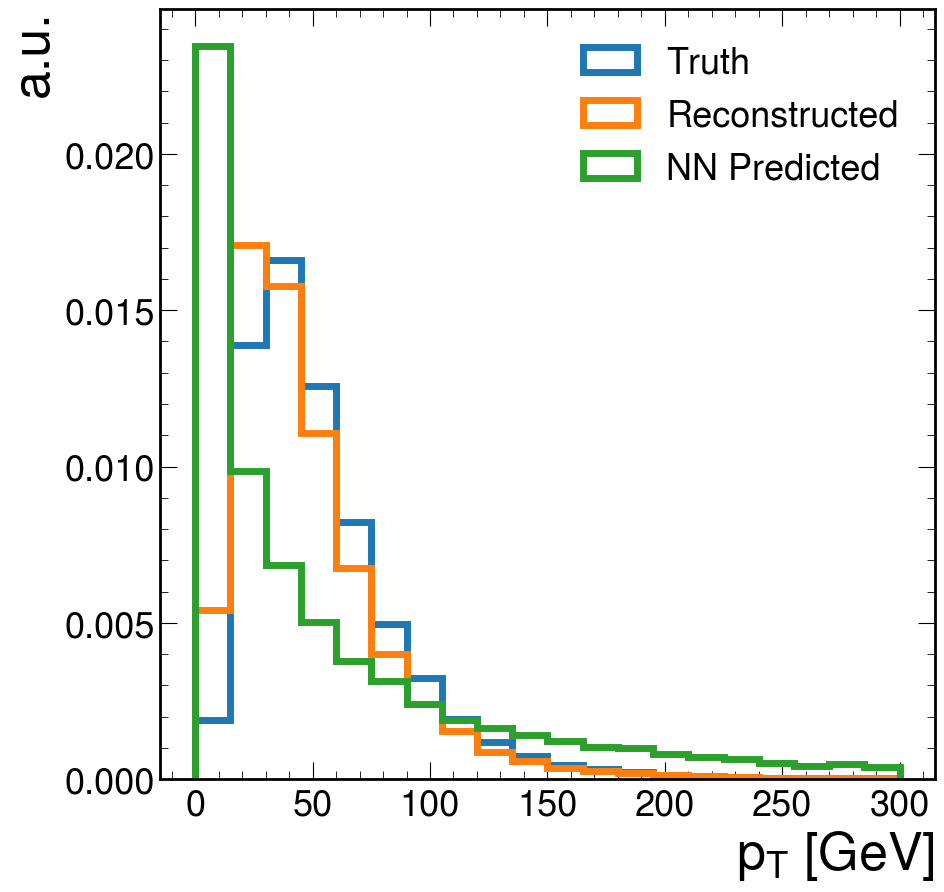

In [17]:
load_and_predict_test("../../ntuples/Jan_25_2023", model)

In [18]:
# Looking nice!! 

## Optimal Gamma using different ROC Curve

In [ ]:
NormalModel = load_model('../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5')
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
model_id = load_model(model_id_name)
model_regress = load_model(model_pt_regress_name)

#Might have to change the version for other ntuple files
data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]

truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)

truth_pt_selected = np.asarray(truth_pt[selection])
reco_pt_selected = np.asarray(reco_pt[selection])
    

y_pred_corrected = model_regress(X_test)
fpr_mono, tpr_mono, _ = roc_curve(y_test, y_pred_mono.detach().numpy())
auc_score_mono = round(auc(fpr_mono, tpr_mono),2)

y_pred_normal = model_id.predict(X_test.detach().numpy())
fpr_normal, tpr_normal, _ = roc_curve(y_test,y_pred_normal)
auc_score_normal = round(auc(fpr_normal, tpr_normal),2)

In [ ]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_mono, tpr_mono, label = 'Tau NN Mono, AUC: {}'.format(auc_score_mono))
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau NN, AUC: {}'.format(auc_score_normal))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

## Scanning Optimal Gamma using ROC Curve

In [25]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
model_id = load_model(model_id_name)
#MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
#MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

In [27]:
sig_lists = []
bkg_lists = []
for i in range(0, len(trained_models), 2):    
    truth_sig_pt_cut = 20.
    test_index = 400000
    #Filter out the test signals
    sig = uproot4.open("../../ntuples/Jan_25_2023/test_sig_v12_emseed.root")
    bkg = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root")

    unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
    unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array())[test_index:])

    #Load model and select out the tau
    model = load_model(model_id_name)

    #Sig
    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]

    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])

    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    X_sig[abs(X_sig) > 1e+4] = 0.

    #
    y_sig = model.predict(X_sig)

    #Bkg
    bkg_input = np.asarray(bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:])
    bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()[test_index:])
    bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:])


    selection_bkg = bkg_pt > 20
    bkg_id_pt = bkg_id[selection_bkg]

    total_n_minbias = np.unique(bkg_id).shape[0]
    total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

    bkg_input[abs(bkg_input) > 1e+4] = 0.
    y_bkg = model.predict(bkg_input[selection_bkg])

    bkg_pass_corrected_ratio = trained_models[i].predict(bkg_input)[1].flatten()
    bkg_pt_corrected = np.multiply(bkg_pt, bkg_pass_corrected_ratio)

    selection_bkg_corrected = bkg_pt_corrected > 20. 

    bkg_id_pt_corrected = bkg_id[selection_bkg_corrected]
    y_bkg_corrected = model.predict(bkg_input[selection_bkg_corrected]).flatten()

    tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list_corrected = []
    bkg_list_corrected = []

    for tau_score_cut in tau_score_edges:

        bkg_pass = np.unique(bkg_id_pt_corrected[y_bkg_corrected > tau_score_cut]).shape[0]
        sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])

        real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]

        sig_list_corrected.append(real_sig_pass/total_n_sig)
        bkg_list_corrected.append(bkg_pass/total_n_minbias)

    bkg_list_scaled = [i*(32e+3) for i in bkg_list_corrected]
    sig_lists.append(sig_list_corrected)
    bkg_lists.append(bkg_list_corrected)

1260/1260 [==============================] - 1s 1ms/step


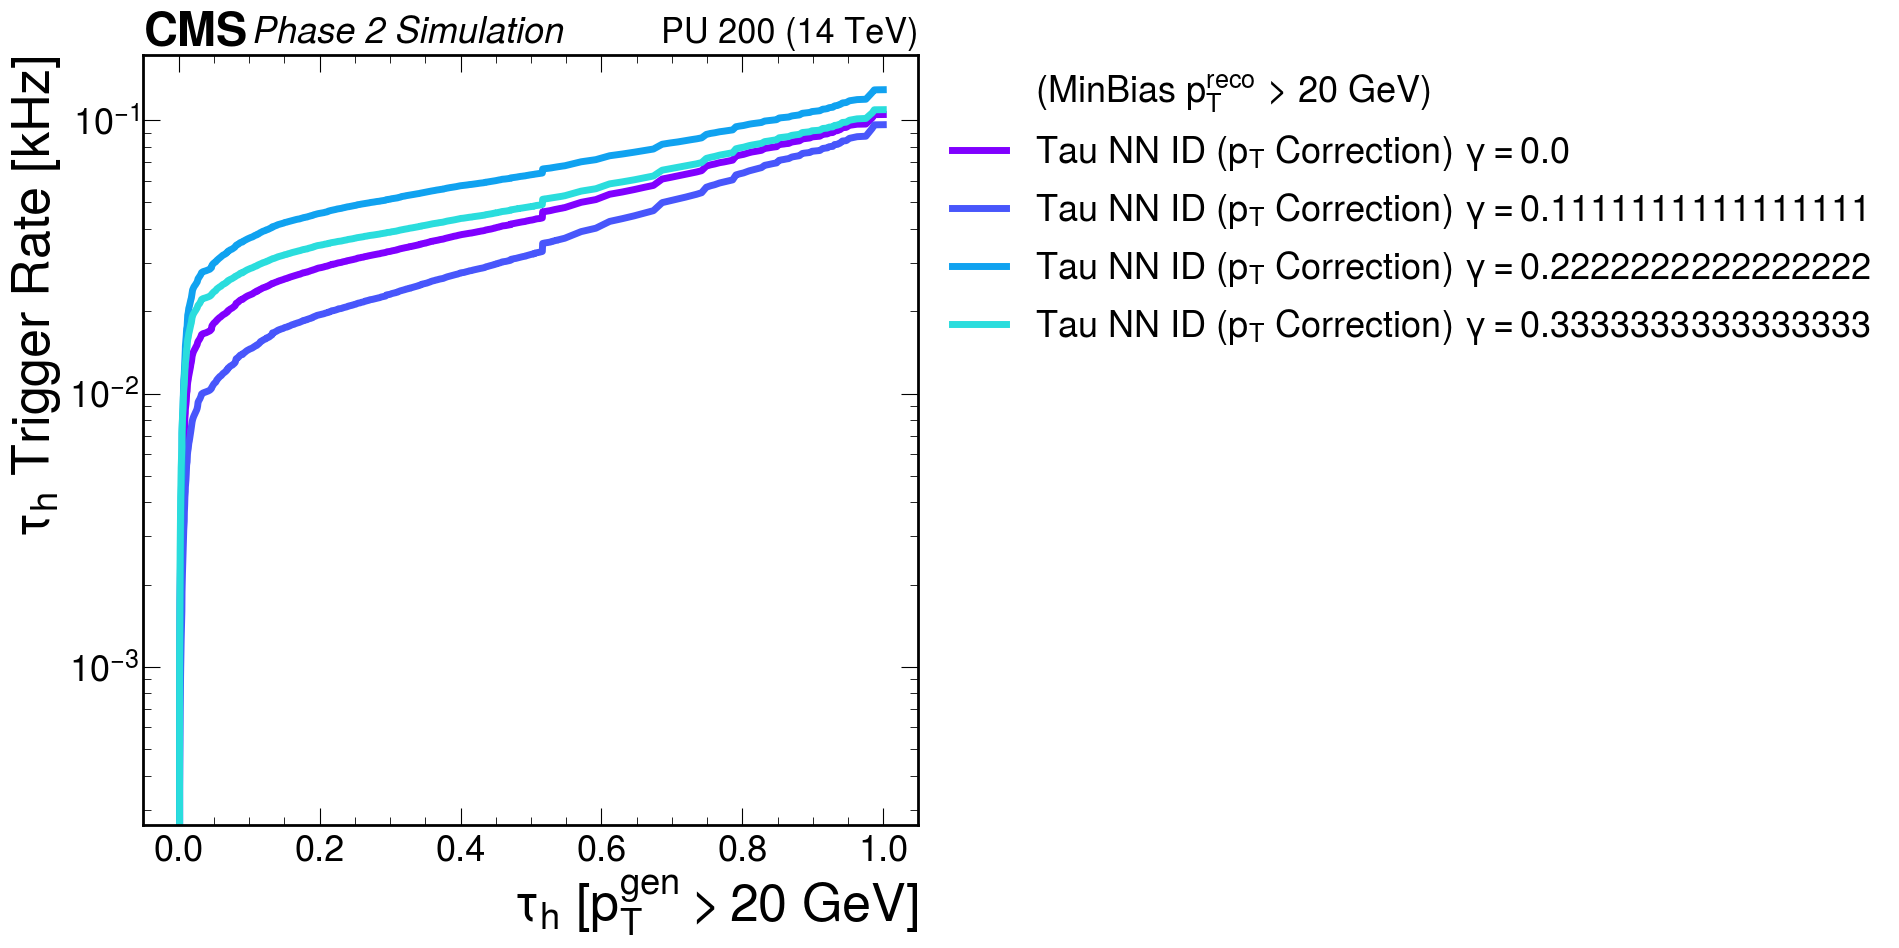

In [34]:
plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco}$ > 20 GeV)')
#plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)

color = iter(cm.rainbow(np.linspace(0, 1, len(trained_models))))
for i in range(int(len(trained_models)/2 - 1)):
    c = next(color)
    plt.plot(sig_lists[i], bkg_lists[i], label=r'Tau NN ID ($p_T$ Correction)' + ' $\gamma=$' + str(gammas[i]), c = c, linewidth=5)
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")

plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

plt.yscale('log')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
#                   [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

# sig_list = []
# bkg_list = []

# for tau_score_cut in tau_score_edges:
    
#     bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
#     sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])

#     real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
#     sig_list.append(real_sig_pass/total_n_sig)
#     bkg_list.append(bkg_pass/total_n_minbias)

    

# bkg_list_scaled = [i*(32e+3) for i in bkg_list]

In [28]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

sig_list_corrected = []
bkg_list_corrected = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt_corrected[y_bkg_corrected > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])

    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list_corrected.append(real_sig_pass/total_n_sig)
    bkg_list_corrected.append(bkg_pass/total_n_minbias)

bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

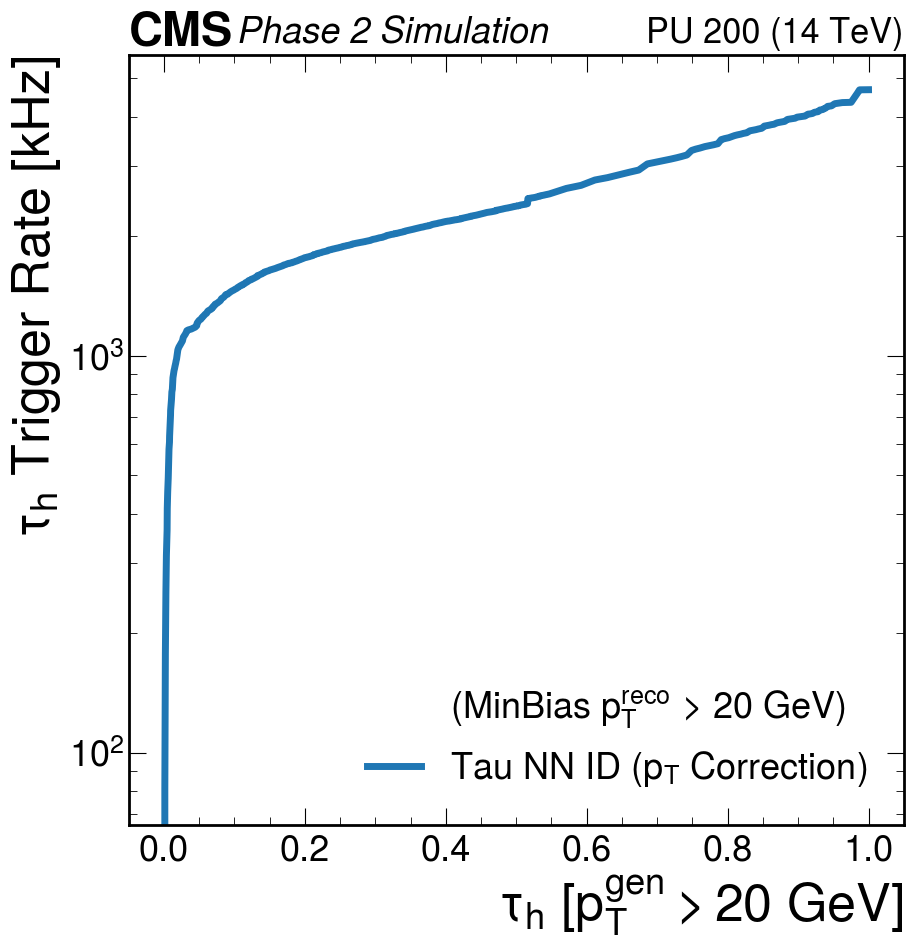

In [29]:
plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco}$ > 20 GeV)')
#plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID ($p_T$ Correction)',linewidth=5)
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")

plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

plt.yscale('log')
plt.legend()
plt.show()

### Resolution + Response Plots

In [ ]:
def bob(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = trained_models[3].predict(X_test)[1].flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
    plt.xlabel("$p_T^{PUPPI} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()


In [ ]:
bob("../../ntuples/Jan_25_2023", trained_models[7])